In [1]:
%matplotlib inline

from itertools import groupby
import numpy as np
import pandas as pd
import scipy
import scipy.signal

#to visualize 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")


#to load files
import os
import h5py

#ML packages
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold


from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model, load_model, Sequential, save_model
from tensorflow. keras.layers import Dense, Activation, Dropout, Input,  TimeDistributed, GRU, Masking, LSTM

from tensorflow.keras.utils import to_categorical


from sklearn.datasets import make_moons, make_blobs

import tensorflow as tf

from EMG_gestures.utils import *

In [143]:


#define custom gradient
@tf.custom_gradient
def GradientReversalOperator(x):
    def grad(dy):
        return -1*dy
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def call(self, inputs):
        return GradientReversalOperator(inputs)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    tmp = np.c_[xx.ravel(), yy.ravel()]
    Z = np.argmax(model.predict(tmp),1)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

class DANN(keras.Model):
    def __init__(self, input_shape, n_outputs, n_source = 2, fe_layers = 0, dp_layers = 0,\
                           drop_prob = 0.5, activation = 'tanh'):
        super(DANN, self).__init__()
        
        #define feature extractor model
        fe_input = Input(shape = input_shape)
        X = fe_input
        for n in range(fe_layers):
            X = Dense(input_shape[0],activation = activation)(X)
            X = Dropout(drop_prob)(X)
        fe_output = X   
        self.feat_extract = Model(inputs = fe_input, outputs = fe_output, name = 'feature_extractor')

        #label-predicting head
        lp_head_input = Input(shape = input_shape)
        lp_head_output = Dense(n_outputs,activation = 'softmax', name = 'label')(lp_head_input)
        self.label_pred = Model(inputs = lp_head_input, outputs = lp_head_output, name = 'label_head')
        
        #domain predicting head
        dp_head_input = Input(shape = input_shape)
        X = GradientReversalLayer()(dp_head_input)#reverse gradient
        for n in range(dp_layers):
            X = Dense(input_shape[0],activation = activation)(X)
            X = Dropout(drop_prob)(X)
        dp_head_output = Dense(n_source,activation = 'softmax', name = 'domain')(X)
        self.domain_pred = Model(inputs = dp_head_input, outputs = dp_head_output, name = 'domain_head')
        

        lp_input = Input(shape = input_shape)
        X = self.feat_extract(lp_input)
        lp_output = self.label_pred(X)
        self.predict_label = Model(inputs = lp_input, outputs = lp_output, name = 'DANN-label')
        
        dp_input = Input(shape = input_shape)
        X = self.feat_extract(dp_input)
        dp_output = self.domain_pred(X)
        self.predict_domain = Model(inputs = dp_input, outputs = dp_output, name = 'DANN-domain')
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.train_lp_loss = tf.keras.metrics.Mean(name = 'lp_loss')
        self.train_lp_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'lp_acc')
        
        self.train_dp_loss = tf.keras.metrics.Mean(name = 'dp_loss')
        self.train_dp_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'dp_acc')
        
    @tf.function
    def train_step_label_pred(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self.predict_label(x, training = True)# Forward pass
            lp_loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)   
        lp_grad = tape.gradient(lp_loss, self.predict_label.trainable_variables)

        self.optimizer.apply_gradients(zip(lp_grad, self.predict_label.trainable_variables))
        
        # Update metrics
        self.train_lp_loss.update_state(lp_loss)
        self.train_lp_accuracy.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def train_step_domain_adapt(self, data):
        x, y = data


        with tf.GradientTape() as tape:
            y_pred = self.predict_domain(x, training = True)# Forward pass
            dp_loss = self.compiled_loss(y, y_pred)
        dp_grad = tape.gradient(dp_loss, self.predict_domain.trainable_variables)
        
        self.optimizer.apply_gradients(zip(dp_grad, self.predict_domain.trainable_variables))
        
        # Update metrics
        self.train_dp_loss.update_state(dp_loss)
        self.train_dp_accuracy.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.train_lp_loss, self.train_lp_accuracy, self.train_dp_loss, self.train_dp_accuracy]

    def train_label_pred(self, X,Y, epochs, batch_size, verbose):

        # Prepare the training dataset.
        train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        for epoch in range(epochs):
            if verbose:
                print('\n Epoch %d/%d'%(epoch+1,epochs))
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                out = self.train_step_label_pred((x_batch_train, y_batch_train))

            #output metrics
            if verbose:
                log_string = ''
                for k in out.keys():
                    log_string = log_string + ' - %s: %.04f '%(k,out[k])
                print(log_string)
            #reset states after every epoch
            self.train_lp_loss.reset_states()
            self.train_lp_accuracy.reset_states()
            
    def train_domain_adapt(self, X, Y, X_domain, epochs, batch_size, verbose):
        
        X_combo = np.vstack((X,X_domain))
        Y_combo_domain = np.hstack((np.ones(X.shape[0],)*0,np.ones(X_domain.shape[0],)*1))#source_label
        Y_combo_domain = to_categorical(Y_combo_domain)

        # Prepare the training dataset.
        train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        train_domain_dataset = tf.data.Dataset.from_tensor_slices((X_combo, Y_combo_domain))
        train_domain_dataset = train_domain_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        
        for epoch in range(epochs):
            if verbose:
                print('\n Epoch %d/%d'%(epoch+1,epochs))
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                out = self.train_step_label_pred((x_batch_train, y_batch_train))
                
#                 for x_domain_batch,y_domain_batch in train_domain_dataset.take(1):
#                     out = self.train_step_domain_adapt((x_domain_batch, y_domain_batch))

                
            for step, (x_domain_batch,y_domain_batch) in enumerate(train_domain_dataset):
                out = self.train_step_domain_adapt((x_domain_batch, y_domain_batch))

            #output metrics
            if verbose:
                log_string = ''
                for k in out.keys():
                    log_string = log_string + ' - %s: %.04f '%(k,out[k])
                print(log_string)
                
            #reset states after every epoch
            self.train_lp_loss.reset_states()
            self.train_lp_accuracy.reset_states()
            self.train_dp_loss.reset_states()
            self.train_dp_accuracy.reset_states()
        
        return
    def train_domain_and_labels(self, X, Y, X_domain, Y_domain, epochs, batch_size, verbose):
        
        X_all = np.vstack((X,X_domain))
        Y_all = np.vstack((Y,Y_domain))
        Y_combo_domain = np.hstack((np.ones(X.shape[0],)*0,np.ones(X_domain.shape[0],)*1))#source_label
        Y_combo_domain = to_categorical(Y_combo_domain)

        # Prepare the training dataset.
        train_dataset = tf.data.Dataset.from_tensor_slices((X_all, Y_all))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        train_domain_dataset = tf.data.Dataset.from_tensor_slices((X_all, Y_combo_domain))
        train_domain_dataset = train_domain_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        
        for epoch in range(epochs):
            if verbose:
                print('\n Epoch %d/%d'%(epoch+1,epochs))
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                out = self.train_step_label_pred((x_batch_train, y_batch_train))
                

            for step, (x_domain_batch,y_domain_batch) in enumerate(train_domain_dataset):
                out = self.train_step_domain_adapt((x_domain_batch, y_domain_batch))

            #output metrics
            if verbose:
                log_string = ''
                for k in out.keys():
                    log_string = log_string + ' - %s: %.04f '%(k,out[k])
                print(log_string)
                
            #reset states after every epoch
            self.train_lp_loss.reset_states()
            self.train_lp_accuracy.reset_states()
            self.train_dp_loss.reset_states()
            self.train_dp_accuracy.reset_states()
        
        return

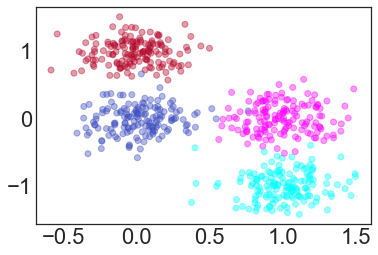

In [2]:
#make fake blob data

X1, y1 = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
X2, y2 = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='coolwarm', alpha=0.4)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='cool', alpha=0.4)

In [135]:
X_train_cube, Y_train_cube, scaler = prepare_data_for_log_reg(X1,y1, np.arange(X1.shape[0]), [], train = True)
X_test_cube, Y_test_cube, scaler = prepare_data_for_log_reg(X2,y2, np.arange(X2.shape[0]), [], scaler = scaler)

#stack
X_all_cube = np.vstack((X_train_cube,X_test_cube))
#
Y_all_cube = np.vstack((Y_train_cube,Y_test_cube))
# create domain labels
Y_all_domain = np.hstack((np.ones(X1.shape[0],)*0,np.ones(X2.shape[0],)*1))#source_label
Y_all_domain = to_categorical(Y_all_domain)


In [7]:
n_features, n_outputs = X_train_cube.shape[1], Y_train_cube.shape[1]

In [28]:
epochs = 20
batch_size = 10
score_list = ['accuracy']

In [136]:
#define and compile model
input_shape = (n_features,)
dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
dann_model.compile(loss='categorical_crossentropy')

In [137]:
np.random.seed(1)
dann_model.train_label_pred(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=0)

In [138]:
#label pred accuracy
train_scores = get_scores(X_train_cube, Y_train_cube, dann_model.predict_label, score_list)
test_scores = get_scores(X_test_cube, Y_test_cube, dann_model.predict_label, score_list)

#domain class accuracy
domain_scores = get_scores(X_all_cube, Y_all_domain, dann_model.predict_domain, score_list)

In [139]:
print(train_scores)
print(test_scores)
print(domain_scores)

0.9933333333333333
0.5
0.6266666666666667


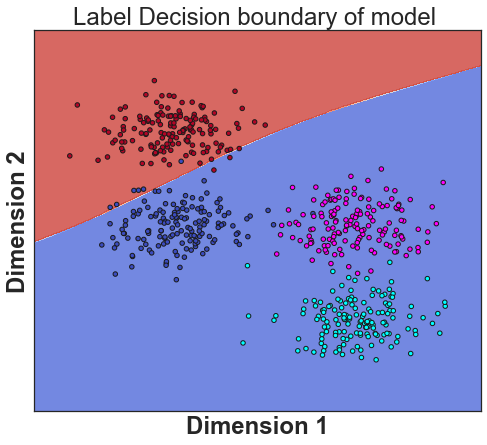

In [112]:
#plot
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Label Decision boundary of model ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

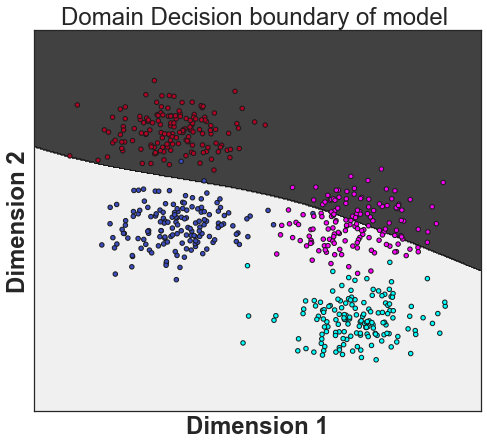

In [97]:
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Domain Decision boundary of model ')
plot_contours(ax, dann_model.predict_domain, xx, yy, cmap=plt.cm.binary, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [140]:
dann_model.train_domain_adapt(X_train_cube, Y_train_cube, X_test_cube,\
                              epochs = epochs*3, batch_size = batch_size, verbose = 0)

In [141]:
#label pred accuracy
train_scores_adapt = get_scores(X_train_cube, Y_train_cube, dann_model.predict_label, score_list)
test_scores_adapt = get_scores(X_test_cube, Y_test_cube, dann_model.predict_label, score_list)

#domain class accuracy
domain_scores_adapt = get_scores(X_all_cube, Y_all_domain, dann_model.predict_domain, score_list)

In [142]:
print(train_scores_adapt)
print(test_scores_adapt)
print(domain_scores_adapt)

0.9966666666666667
0.5266666666666666
0.75


In [ ]:



0.9966666666666667
0.5433333333333333
0.725

0.9833333333333333
0.8066666666666666
0.5883333333333334


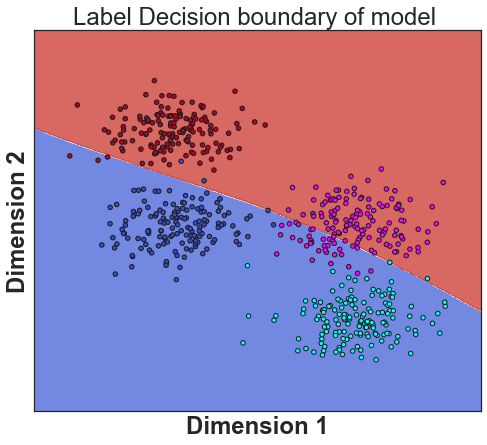

In [84]:

# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Label Decision boundary of model ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

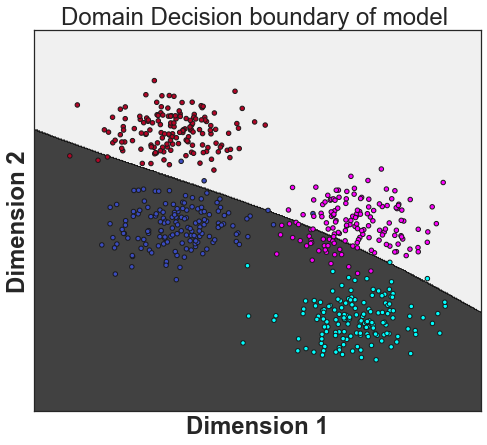

In [85]:
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Domain Decision boundary of model ')
plot_contours(ax, dann_model.predict_domain, xx, yy, cmap=plt.cm.binary, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [151]:
# with labels revealed

#define and compile model
input_shape = (n_features,)
dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
dann_model.compile(loss='categorical_crossentropy')

In [152]:
np.random.seed(1)
dann_model.train_domain_and_labels(X_train_cube, Y_train_cube, X_test_cube, Y_test_cube,\
                                   epochs=epochs*2, batch_size=batch_size, verbose=1)


 Epoch 1/40
 - lp_loss: 1.0335  - lp_acc: 0.5983  - dp_loss: 0.7090  - dp_acc: 0.5817 

 Epoch 2/40
 - lp_loss: 0.9295  - lp_acc: 0.5933  - dp_loss: 0.6899  - dp_acc: 0.5583 

 Epoch 3/40
 - lp_loss: 0.8241  - lp_acc: 0.6033  - dp_loss: 0.7033  - dp_acc: 0.5150 

 Epoch 4/40
 - lp_loss: 0.6589  - lp_acc: 0.6367  - dp_loss: 0.7316  - dp_acc: 0.4650 

 Epoch 5/40
 - lp_loss: 0.5327  - lp_acc: 0.7167  - dp_loss: 0.7439  - dp_acc: 0.4750 

 Epoch 6/40
 - lp_loss: 0.5205  - lp_acc: 0.7250  - dp_loss: 0.7477  - dp_acc: 0.4617 

 Epoch 7/40
 - lp_loss: 0.5042  - lp_acc: 0.7333  - dp_loss: 0.7345  - dp_acc: 0.4900 

 Epoch 8/40
 - lp_loss: 0.4687  - lp_acc: 0.7500  - dp_loss: 0.7156  - dp_acc: 0.4583 

 Epoch 9/40
 - lp_loss: 0.4831  - lp_acc: 0.7500  - dp_loss: 0.7105  - dp_acc: 0.4950 

 Epoch 10/40
 - lp_loss: 0.4885  - lp_acc: 0.7300  - dp_loss: 0.7003  - dp_acc: 0.5217 

 Epoch 11/40
 - lp_loss: 0.4609  - lp_acc: 0.7567  - dp_loss: 0.6886  - dp_acc: 0.5733 

 Epoch 12/40
 - lp_loss: 0.44

In [153]:
#label pred accuracy
train_scores_lr = get_scores(X_train_cube, Y_train_cube, dann_model.predict_label, score_list)
test_scores_lr = get_scores(X_test_cube, Y_test_cube, dann_model.predict_label, score_list)

#domain class accuracy
domain_scores_lr = get_scores(X_all_cube, Y_all_domain, dann_model.predict_domain, score_list)

In [154]:
print(train_scores_lr)
print(test_scores_lr)
print(domain_scores_lr)

0.96
0.96
0.49166666666666664


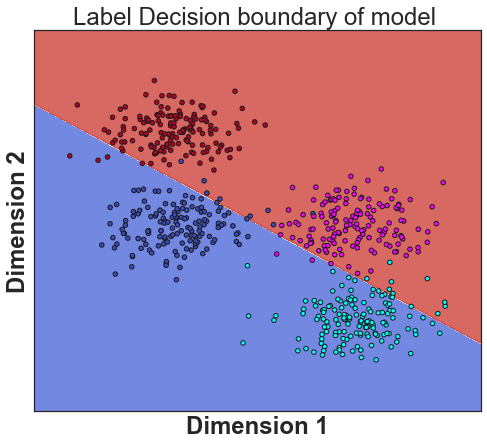

In [155]:
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Label Decision boundary of model ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

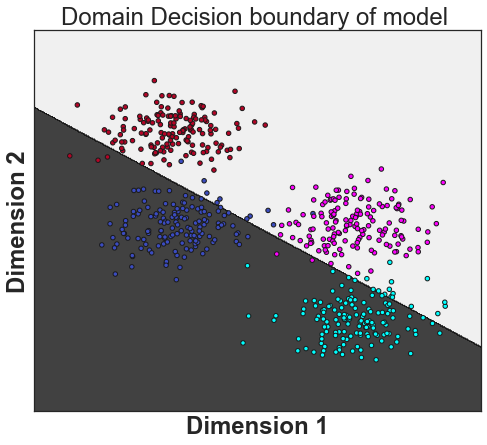

In [156]:
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_all_cube[:,0], X_all_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Domain Decision boundary of model ')
plot_contours(ax, dann_model.predict_domain, xx, yy, cmap=plt.cm.binary, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_test_cube[:,0], X_test_cube[:,1], c=np.argmax(Y_test_cube,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [286]:
epochs = 20
batch_size = 10
score_list = ['accuracy']
n_splits = 3
nreps = 2


np.random.seed(1)
results_df = []
for rep in range(nreps):
    print('Rep %d'%(rep+1))
    
    sub_df = DANN_test(X1, y1, X2, y2, score_list, n_splits,\
                           epochs, batch_size)
    sub_df['Rep'] = rep+1
    sub_df['Shuffled'] = False
    
    results_df.append(sub_df)
    sub_df = DANN_test(X1, y1, X2, y2, score_list, n_splits,\
                           epochs, batch_size, permute = True)
    sub_df['Rep'] = rep+1
    sub_df['Shuffled'] = True
    results_df.append(sub_df)
    
results_df = pd.concat(results_df, axis = 0)

Rep 1
Split Count: 1
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 2
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 3
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 1
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 2
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 3
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Rep 2
Split Count: 1
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 2
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 3
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 1
Training on Source Labels
Adapting to target Domain
Training wit

In [288]:
results_df.groupby(['Shuffled','Type'])\
.mean()\
.drop(columns = ['Fold','Rep'])

accuracy_score
Shuffled Type                                 
False    Adapt_Source_Test            0.985000
         Adapt_Target_Test            0.720000
         Adapt_Target_Train           0.710833
         Naive_Target_Test            0.551667
         Naive_Target_Train           0.542500
         Revealed_Source_Test         0.791667
         Revealed_Source_Train        0.807500
         Revealed_Target_Test         0.791667
         Revealed_Target_Train        0.834167
         Source_Test                  0.870000
         Source_Train                 0.868333
True     Adapt_Source_Test            0.485000
         Adapt_Target_Test            0.510000
         Adapt_Target_Train           0.504167
         Naive_Target_Test            0.495000
         Naive_Target_Train           0.501667
         Revealed_Source_Test         0.511667
         Revealed_Source_Train        0.501667
         Revealed_Target_Test         0.511667
         Revealed_Target_Train        0.503333
         Source_Test                  0.481667
         Source_Train                 0.512500

In [300]:
keep_types = ['Source_Test','Naive_Target_Test','Adapt_Source_Test']
plot_df = results_df.loc[results_df.Type.isin(keep_types)]
plot_df = plot_df.groupby(['Type','Shuffled','Rep'])\
.mean()\
.drop(columns = ['Fold'])\
.reset_index()

shuffle_df = plot_df.loc[plot_df.Shuffled == True]
true_df = plot_df.loc[plot_df.Shuffled == False]

In [302]:
# Get confidence interval for shuffled data results

null_ci = np.zeros((len(keep_types),2))


for j,t in enumerate(keep_types):
    null_df = shuffle_df.loc[shuffle_df.Type == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df['accuracy_score'].values))


array([0.45333333, 0.51      ])

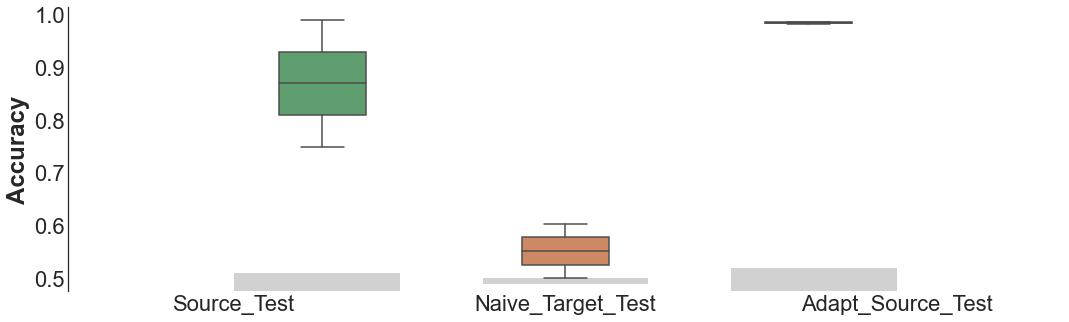

In [330]:
g = sns.catplot(data = true_df, x= 'Type', y = 'accuracy_score', hue = 'Type',\
            order = keep_types, kind = 'box', aspect = 3)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_xticklabels(keep_types,horizontalalignment = 'center')
    ax.set_ylabel('Accuracy')
    for j,t in enumerate(keep_types):
        ax.add_patch(patches.Rectangle((.75*j, null_ci[j,0]), 0.5, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))
#     ax.add_patch(patches.Rectangle((.75, null_ci[0,0]), 0.5, (null_ci[0,1]-null_ci[0,0]),\
#                                          linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = True)

In [312]:
g.axes

array([[<AxesSubplot:xlabel='Type', ylabel='accuracy_score'>]],
      dtype=object)

In [ ]:

#stack
X_all_cube =
#
Y_all_cube = np.vstack((Y_train_cube,Y_test_cube))
# create domain labels
Y_all_domain = np.hstack((np.ones(X1.shape[0],)*0,np.ones(X2.shape[0],)*1))#source_label
Y_all_domain = to_categorical(Y_all_domain)

In [ ]:
source_X = X1.copy()
source_Y = y1.copy()
target_X = X2.copy()
target_Y = y2.copy()

n_splits = 3
np.random.seed(1)

In [ ]:
def results_to_df(df, n_splits, score_list, scores_array, type_label):
    """"
    Append results to list for df conversion
    """
    data_dict = {'Type':[type_label for x in range(n_splits)],\
                 'Fold':np.arange(n_splits)+1}
    for sidx in range(len(score_list)):
        data_dict['%s_score'%(score_list[sidx])] = scores_array[:,sidx]
    df.append(pd.DataFrame(data_dict))
    
    return df

In [284]:
def DANN_test(source_X, source_Y, target_X, target_Y, score_list, n_splits, epochs, batch_size,\
              permute = False):

    if permute:
        #scramble class labels
        source_Y = np.random.permutation(source_Y)
        target_Y = np.random.permutation(target_Y)
        
    #put together labels
    all_X =  np.vstack((source_X,target_X))
    all_Y = np.hstack((source_Y, target_Y))
    
    domain_Y = np.hstack((np.ones(source_X.shape[0],)*0,np.ones(source_X.shape[0],)*1))#source_label


    skf = StratifiedKFold(n_splits=n_splits)

    #initialize empty arrays
    n_scores = len(score_list)

    source_train_scores = np.empty((n_splits,n_scores))
    source_test_scores = np.empty((n_splits,n_scores))

    naive_target_train_scores = np.empty((n_splits,n_scores))
    naive_target_test_scores = np.empty((n_splits,n_scores))

    adapt_source_test_scores  = np.empty((n_splits,n_scores))
    adapt_target_train_scores  = np.empty((n_splits,n_scores))
    adapt_target_test_scores  = np.empty((n_splits,n_scores))

    revealed_source_train_scores = np.empty((n_splits,n_scores))
    revealed_source_test_scores = np.empty((n_splits,n_scores))
    revealed_target_train_scores = np.empty((n_splits,n_scores))
    revealed_target_test_scores = np.empty((n_splits,n_scores))

    #re-code so that stratified split preserves both label and comain fractions
    dummy_Y = all_Y+(domain_Y*(np.max(all_Y)+1))

    for split_count,(train_idxs, test_idxs) in enumerate(skf.split(all_X, dummy_Y)):
        print('Split Count: %d'%(split_count+1))

        #get indices
        source_train_idxs =  np.intersect1d(train_idxs,np.where(dummy_Y<2)[0])
        source_test_idxs = np.intersect1d(test_idxs,np.where(dummy_Y<2)[0])
        target_train_idxs = np.intersect1d(train_idxs,np.where(dummy_Y>=2)[0])
        target_test_idxs = np.intersect1d(test_idxs,np.where(dummy_Y>=2)[0])

        #prepare data for neural net
        source_train_X, source_train_Y, scaler = prepare_data_for_log_reg(all_X, all_Y, source_train_idxs,\
                                                                          [], train = True)
        source_test_X, source_test_Y, scaler = prepare_data_for_log_reg(all_X, all_Y, source_test_idxs,\
                                                                        [], scaler = scaler)
        target_train_X, target_train_Y, scaler = prepare_data_for_log_reg(all_X, all_Y, target_train_idxs,\
                                                                          [], scaler = scaler)
        target_test_X, target_test_Y, scaler = prepare_data_for_log_reg(all_X, all_Y, target_test_idxs,\
                                                                        [], scaler = scaler)

        n_features, n_outputs = source_train_X.shape[1], source_train_Y.shape[1]

        #define and compile model
        input_shape = (n_features,)
        dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
        dann_model.compile(loss='categorical_crossentropy')

        #train on source labels
        print('Training on Source Labels')
        dann_model.train_label_pred(source_train_X, source_train_Y, epochs=epochs, batch_size=batch_size, verbose=0)

        #score on source data
        source_train_scores[split_count,:] = get_scores(source_train_X, source_train_Y, dann_model.predict_label, score_list)
        source_test_scores[split_count,:] = get_scores(source_test_X, source_test_Y, dann_model.predict_label, score_list)
        #score on target data (naive transfer test)
        naive_target_train_scores[split_count,:] = get_scores(target_train_X, target_train_Y, dann_model.predict_label, score_list)
        naive_target_test_scores[split_count,:] = get_scores(target_test_X, target_test_Y, dann_model.predict_label, score_list)

        #train same model with domain labels of target
        print('Adapting to target Domain')
        dann_model.train_domain_adapt(source_train_X, source_train_Y, target_train_X,\
                                      epochs = epochs*3, batch_size = batch_size, verbose = 0)

        #score on source data
        adapt_source_test_scores[split_count,:] = get_scores(source_test_X, source_test_Y, dann_model.predict_label,\
                                                             score_list)
        #score on target data
        adapt_target_train_scores[split_count,:]  = get_scores(target_train_X, target_train_Y, dann_model.predict_label,\
                                                             score_list)
        adapt_target_test_scores[split_count,:]  = get_scores(target_test_X, target_test_Y, dann_model.predict_label,\
                                                             score_list)

        # for comparison, use all available labels 
        # define and compile model
        input_shape = (n_features,)
        dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
        dann_model.compile(loss='categorical_crossentropy')
        print('Training with all labels revealed')
        dann_model.train_domain_and_labels(source_train_X, source_train_X, target_train_X, target_train_Y,\
                                           epochs=epochs*2, batch_size=batch_size, verbose=0)

        revealed_source_train_scores[split_count,:] = get_scores(source_train_X, source_train_Y, dann_model.predict_label,\
                                                             score_list)
        revealed_source_test_scores[split_count,:] = get_scores(source_test_X, source_test_Y, dann_model.predict_label,\
                                                             score_list)
        revealed_target_train_scores[split_count,:] = get_scores(target_train_X, target_train_Y, dann_model.predict_label,\
                                                             score_list)
        revealed_target_test_scores[split_count,:] = get_scores(target_test_X, target_test_Y, dann_model.predict_label,\
                                                             score_list)

    #score arrays in dataframes
    results_df = []

    results_df = results_to_df(results_df, n_splits, score_list,\
                               source_train_scores, 'Source_Train')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               source_test_scores, 'Source_Test')

    results_df = results_to_df(results_df, n_splits, score_list,\
                               naive_target_train_scores, 'Naive_Target_Train')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               naive_target_test_scores, 'Naive_Target_Test')

    results_df = results_to_df(results_df, n_splits, score_list,\
                               adapt_source_test_scores, 'Adapt_Source_Test')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               adapt_target_train_scores, 'Adapt_Target_Train')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               adapt_target_test_scores, 'Adapt_Target_Test')

    results_df = results_to_df(results_df, n_splits, score_list,\
                               revealed_source_train_scores, 'Revealed_Source_Train')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               revealed_source_test_scores, 'Revealed_Source_Test')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               revealed_target_train_scores, 'Revealed_Target_Train')
    results_df = results_to_df(results_df, n_splits, score_list,\
                               revealed_source_test_scores, 'Revealed_Target_Test')
    results_df = pd.concat(results_df, axis = 0)

    return results_df

In [ ]:
print(revealed_source_train_scores)
print(revealed_source_test_scores)
print(revealed_target_train_scores)
print(revealed_target_test_scores)

In [278]:
results_df

,Type,Fold,accuracy_score
0,Source_Train,1,0.795
1,Source_Train,2,0.755
2,Source_Train,3,0.995
0,Source_Test,1,0.830
1,Source_Test,2,0.690
2,Source_Test,3,1.000
0,Naive_Target_Train,1,0.520
1,Naive_Target_Train,2,0.500
2,Naive_Target_Train,3,0.500
0,Naive_Target_Test,1,0.500


In [264]:
print(source_train_scores)
print(source_test_scores)
print(naive_target_train_scores)
print(naive_target_test_scores)

[[0.795]
 [0.755]
 [0.995]]
[[0.83]
 [0.69]
 [1.  ]]
[[0.52]
 [0.5 ]
 [0.5 ]]
[[0.5 ]
 [0.51]
 [0.5 ]]


In [265]:
print(adapt_source_test_scores)

[[0.97]
 [1.  ]
 [0.98]]


In [266]:
print(adapt_target_train_scores)

[[0.915]
 [0.64 ]
 [0.915]]


In [267]:
print(adapt_target_test_scores)

[[0.9 ]
 [0.68]
 [0.89]]


In [268]:
print(revealed_source_train_scores)
print(revealed_source_test_scores)
print(revealed_target_train_scores)
print(revealed_target_test_scores)

[[0.875]
 [0.975]
 [0.935]]
[[0.85]
 [0.99]
 [0.94]]
[[0.915]
 [0.5  ]
 [0.915]]
[[0.9]
 [0.5]
 [0.9]]
